# SNN on MNIST

In this notebook I train a Spiking Neural network on the MNIST dataset



### Imports

In [3]:

import matplotlib.pyplot as plt
import snntorch.functional as sf
import torch.functional as tsf
import snntorch as snn
from snntorch import spikegen
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.signal import savgol_filter
import numpy as np

from torchmetrics.classification import MulticlassAccuracy

### Spiking Network

Here I define the spiking network with leaky neurons in the hidden and output layer.


In [66]:

class Net(nn.Module):
    '''Spiking Neural network'''
    def __init__(self, num_inputs, num_hiddens, num_outputs, beta, num_steps):
        super().__init__()

        self.num_inputs = num_inputs # number of inputs
        self.num_hidden = num_hiddens # number of hidden neurons
        self.num_outputs = num_outputs # number of output neurons

        self.num_steps = num_steps # number of timesteps per sample

        # initialize layers
        self.fc1 = nn.Linear(self.num_inputs, self.num_hidden) # connection input and hidden layer
        self.lif1 = snn.Leaky(beta=beta) # hidden layer
        self.fc2 = nn.Linear(self.num_hidden, self.num_outputs) # connection hidden layer and output
        self.lif2 = snn.Leaky(beta=beta) # output layer

    def forward(self, data):
        '''Run the network for ``num_steps`` with ``data`` as input. Output spiketrains of outputs'''
        # initialize membrane potentials for hidden and output layer
        mem_hid = self.lif1.init_leaky()
        mem_out = self.lif1.init_leaky()

        spike_out_rec = []

        data = self.gen_spike_trains(data, self.num_steps)

        for i in range(self.num_steps):
            input = self.fc1(data[i])
            spike_hid, mem_hid = self.lif1(input, mem_hid)
            hidden_out = self.fc2(spike_hid)
            spike_out, mem_out = self.lif2(hidden_out, mem_out)

            spike_out_rec.append(spike_out)

        return torch.stack(spike_out_rec)
    
    def gen_spike_trains(self, data, n_steps):
        ''' Generate spike train
            In: [num_steps, batch, input_size]
            Out: [num_steps, batch, input_size]
        '''
        spike_data = spikegen.rate(data, num_steps=n_steps)
        return spike_data

### Helper functions to import data and plot the accuracy

In [5]:

def import_data():
    # Define a transform
    transform = transforms.Compose([
                transforms.Resize((28,28)),
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))])

    mnist_train = datasets.MNIST("/dataset/", train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST("/dataset/", train=False, download=True, transform=transform)

    train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=64) 
    
    return train_loader, test_loader


In [6]:


def plot_accuracy(acc_hist, title, test=False):
    plt.plot(acc_hist)
    plt.title(title)
    plt.xlabel("Epoch" if test else "Batch")
    plt.ylabel("Accuracy")
    # plt.savefig(title+".png")
    plt.show()

def plot_loss(loss_hist, title):
    plt.plot(loss_hist)
    plt.title(title)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    # plt.savefig(title+".png")
    plt.show()


In [7]:

def test_accuracy(data_loader, net, accuracy):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    data_loader = iter(data_loader)
    for data, targets in data_loader:
      spk_rec = net(data.squeeze().flatten(1))

      acc += accuracy(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total


### Train loop for the snn

In [8]:

def train(net:nn.Module, optimizer, loss_fn, accuracy, train_loader, test_loader, epochs):
    '''Training loop for snn'''

    acc_hist = []
    loss_hist = []
    test_acc_hist = []
    acc_per_epoch = []

    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tqepch:
            tqepch.set_description(desc=f"Epoch {epoch}")
            for data, label in tqepch:
                # set net to training mode
                net.train()

                data = data.squeeze().flatten(1)

                # do forward pass
                output = net(data)

                # calculate loss value
                loss_val = loss_fn(output, label)
                loss_hist.append(loss_val.item())

                # clear previously stored gradients
                optimizer.zero_grad()

                # calculate the gradients
                loss_val.backward()

                # weight update
                optimizer.step()

                # determine batch accuracy
                acc = accuracy(output, label)
                acc_hist.append(acc)

                tqepch.set_postfix(loss=loss_val.item(), accuracy=f'{acc * 100:.2f}')

        # accuracy per epoch
        acc_per_epoch.append(acc_hist)

        # accuracy on test set for epoch
        test_acc = test_accuracy(test_loader, net, accuracy)
        test_acc_hist.append(test_acc)
        
        print(f'Test accuracy: {test_acc * 100:.2f}%')

    # take the mean of all the epochs
    acc_per_epoch = np.mean(acc_per_epoch, axis=0)
    
    # smoothing
    acc_per_epoch = savgol_filter(acc_per_epoch,10,1)
    loss_hist = savgol_filter(loss_hist,10,1)

    # plot
    # plot_accuracy(acc_per_epoch, "Train accuracy", 1)
    # plot_loss(loss_hist, "Train loss", 2)
    # plot_accuracy(test_acc_hist, "Test accuracy", 3, test=True)

    # return trained network
    return net, test_acc_hist


### Hyper parameters

In [9]:

# number of epochs
epochs = 20

# number of time steps
n_steps = 25 #ms

# neuron counts
inputs = 28 * 28
hiddens = 200
outputs = 10

# import training and test data
train_loader, test_loader = import_data()

# membrane potential decay
decay = 0.9


### Train command for the snn

In [ ]:

print("SNN:")

# initialize net
net = Net(inputs, hiddens, outputs, decay, n_steps)

# optimization algoritm
optimizer = torch.optim.Adam(net.parameters()) # (NOTE: Adam stond in de tutorial misschien beter algoritme)

# loss function
loss_fn = sf.ce_count_loss() # type: ignore

accuracy = sf.accuracy_rate

trained_snn, test_acc_snn = train(net, optimizer, loss_fn, accuracy, train_loader, test_loader, 1)


#### Test net on single img

In [ ]:

data = next(iter(train_loader))[0].squeeze()

img = 0

plt.imshow(data[img],cmap="Greys")

output = net.forward(data.flatten(1))

fig, ax = plt.subplots(5,2)

for i in range(5):
    for j in range(2):
        ax[i][j].plot(output[:,img,2*i+j].detach().numpy())
        ax[i][j].set_title(f'{2*i+j}')
        ax[i][j].set_ybound(-0.2,1.2)

fig.tight_layout()


### Train command for Feed Forward net

In [ ]:

feed_fwd_net = nn.Sequential(nn.Linear(inputs, hiddens),
                            nn.ReLU(),
                            nn.Linear(hiddens, outputs))

# optimization algoritm
optimizer = torch.optim.Adam(feed_fwd_net.parameters()) # (NOTE: Adam stond in de tutorial misschien beter algoritme)

# loss function
loss_fn = nn.CrossEntropyLoss()

accuracy = MulticlassAccuracy(num_classes=outputs)

print("FFN:")
trained_feed_fwd, test_acc_feed = train(feed_fwd_net, optimizer, loss_fn, accuracy, train_loader, test_loader, epochs)


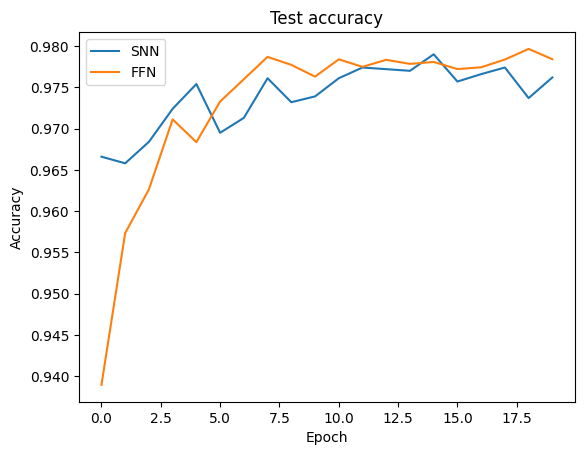

In [268]:

# plot_accuracy(test_acc_feed, "Test accuracy", 3, test=True)

# fig = plt.figure(3)

fig = plt.figure(1)
plt.plot(test_acc_snn, label="SNN")
plt.plot(test_acc_feed, label="FFN")
plt.title("Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig(title+".png")
plt.show()
